In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio

In [33]:
LABELS_DIR = "/fab3/btech/2022/snehanshu.pal22b/SolarPanel/labels/labels_native"
IMAGES_DIR = "/fab3/btech/2022/snehanshu.pal22b/SolarPanel/image_chips_native-20250212T103727Z-001/image_chips_native"


DEFAULT_METERS_PER_PIXEL = 0.31  

def get_meters_per_pixel(tiff_path):
    
    try:
        with rasterio.open(tiff_path) as src:
            transform = src.transform
            meters_per_pixel = abs(transform.a)  
            return meters_per_pixel
    except Exception as e:
        print(f"Could not read {tiff_path}: {e}")
        return DEFAULT_METERS_PER_PIXEL  

def match_labels_to_images():
   
    
    label_files = sorted([f for f in os.listdir(LABELS_DIR) if f.endswith(".txt")])
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith(".tif")])
    
    
    label_map = {os.path.splitext(f)[0]: f for f in label_files}
    image_map = {os.path.splitext(f)[0]: f for f in image_files}

    
    matched_pairs = []
    for base_name in label_map:
        if base_name in image_map:  
            matched_pairs.append((label_map[base_name], image_map[base_name]))
            # print(f"Matched: {base_name}")

    return matched_pairs


In [34]:
def analyze_label_distribution(matched_pairs):
    
    label_counts = []
    
    
    for label_file, _ in matched_pairs:
        with open(os.path.join(LABELS_DIR, label_file), "r") as file:
            num_labels = len(file.readlines())
            label_counts.append(num_labels)
    
    
    min_labels = min(label_counts)
    max_labels = max(label_counts)
    
    
    distribution = {}
    for count in range(min_labels, max_labels + 1):
        num_images = label_counts.count(count)
        if num_images > 0:  
            distribution[count] = num_images
    
    
    df = pd.DataFrame.from_dict(distribution, orient='index', columns=['Number of Images'])
    df.index.name = 'Number of Labels'
    
    return df

def count_solar_panels(matched_pairs):
    """Counts total instances of solar panels and label distribution per image."""
    total_instances = 0
    label_counts = []

    for label_file, _ in matched_pairs:
        with open(os.path.join(LABELS_DIR, label_file), "r") as file:
            lines = file.readlines()
            count = sum(1 for line in lines if line.split()[0] == '0')  # Count only instances with class label 0
            total_instances += count
            label_counts.append(count)

    return total_instances, label_counts


In [35]:
matched_pairs = match_labels_to_images()

total_instances, label_counts = count_solar_panels(matched_pairs)

label_distribution = analyze_label_distribution(matched_pairs)

In [36]:
with open('Q1_results.txt', 'w') as f:
    
    f.write(f"Total number of solar panel instances: {total_instances}\n\n")
    
    
    f.write("Distribution of labels per image:\n")
    f.write("--------------------------------\n")
    f.write(label_distribution.to_string())

In [37]:
def compute_area_statistics(matched_pairs):

    areas = []

    for label_file, image_file in matched_pairs:
        image_path = os.path.join(IMAGES_DIR, image_file)
        meters_per_pixel = get_meters_per_pixel(image_path)

        with open(os.path.join(LABELS_DIR, label_file), "r") as file:
            for line in file:
                parts = line.strip().split()
                class_label = int(parts[0])  
                
            
                if class_label == 0:
                    _, _, _, width, height = map(float, parts)  
                    
                   
                    width_m = width * meters_per_pixel
                    height_m = height * meters_per_pixel
                    
                    area = width_m * height_m  
                    areas.append(area)

    
    mean_area = np.mean(areas) if areas else 0
    std_area = np.std(areas) if areas else 0

    return areas, mean_area, std_area

def plot_area_histogram(areas):
    """Plots the histogram of computed areas."""
    plt.figure(figsize=(8, 5))
    plt.hist(areas, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel("Area (sq. meters)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Solar Panel Areas")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    


Mean Area: 0.01 sq. meters
Standard Deviation: 0.04 sq. meters


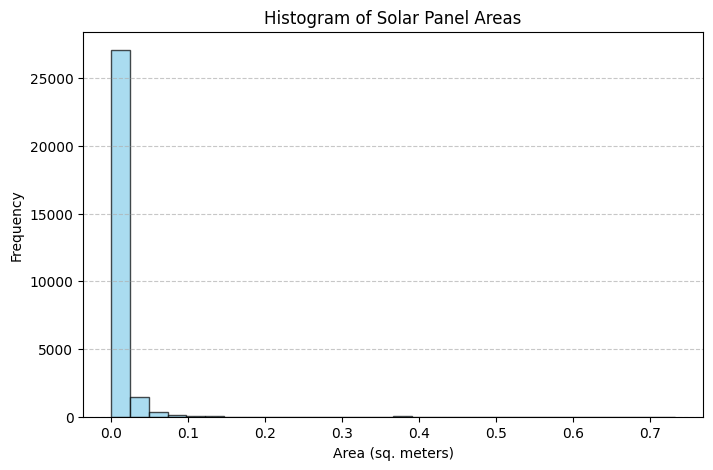

In [38]:
areas, mean_area, std_area = compute_area_statistics(matched_pairs)
print(f"\nMean Area: {mean_area:.2f} sq. meters")
print(f"Standard Deviation: {std_area:.2f} sq. meters")


plot_area_histogram(areas)

# Observations from the Histogram of Solar Panel Areas

- **Highly Skewed Distribution**: The histogram is heavily right-skewed, indicating that most solar panel areas are very small.  
- **Majority of Areas are Small**: A large number of data points fall within the smallest bin, suggesting that most panels in the dataset have very small surface areas.  
- **Few Large Panels**: There are very few instances of larger panel areas (above 0.1 square meters), as seen in the long right tail of the distribution.  
- **Possible Data Issues**: The extreme concentration near zero might indicate:
  - Measurement precision issues.
  - The dataset including many small or partial solar panel installations.
  - Potential data entry inconsistencies.

In [39]:
from shapely.geometry import box
from sklearn.metrics import auc
import random
from shapely.geometry import box 

In [40]:
def compute_iou(box1, box2):
    
    polygon1 = box(*box1)
    polygon2 = box(*box2)
    
    if not polygon1.intersects(polygon2):
        return 0.0
    
    intersection_area = polygon1.intersection(polygon2).area
    union_area = polygon1.union(polygon2).area
    
    return intersection_area / union_area

def pascal_voc_11_point_ap(recalls, precisions):
    
    ap = 0.0
    for t in np.linspace(0, 1, 11):
        p = np.max(precisions[recalls >= t]) if np.sum(recalls >= t) != 0 else 0
        ap += p / 11.0
    return ap

def coco_101_point_ap(recalls, precisions):
   
    ap = 0.0
    for t in np.linspace(0, 1, 101):
        p = np.max(precisions[recalls >= t]) if np.sum(recalls >= t) != 0 else 0
        ap += p / 101.0
    return ap

def auc_pr_ap(recalls, precisions):
    
    return auc(recalls, precisions)

def compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5):
    
    tp = 0
    fp = 0
    fn = len(gt_boxes)
    
    for pred_box in pred_boxes:
        ious = [compute_iou(pred_box, gt_box) for gt_box in gt_boxes]
        if max(ious) >= iou_threshold:
            tp += 1
            fn -= 1
        else:
            fp += 1
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return precision, recall




In [41]:
def generate_random_boxes(image_size, box_size, num_boxes):
    """Generate random bounding boxes within the given image size."""
    boxes = []
    for _ in range(num_boxes):
        x_min = random.randint(0, image_size - box_size)
        y_min = random.randint(0, image_size - box_size)
        x_max = x_min + box_size
        y_max = y_min + box_size
        boxes.append((x_min, y_min, x_max, y_max))
    return boxes


In [42]:
image_size = 100
box_size = 20
num_images = 10
num_boxes = 10
iou_threshold = 0.5

precisions = []
recalls = []

for _ in range(num_images):
    gt_boxes = generate_random_boxes(image_size, box_size, num_boxes)
    pred_boxes = generate_random_boxes(image_size, box_size, num_boxes)
    
    precision, recall = compute_precision_recall(gt_boxes, pred_boxes, iou_threshold)
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)

# Sort by recall
sorted_indices = np.argsort(recalls)
recalls = recalls[sorted_indices]
precisions = precisions[sorted_indices]

ap_voc = pascal_voc_11_point_ap(recalls, precisions)
ap_coco = coco_101_point_ap(recalls, precisions)
ap_auc = auc_pr_ap(recalls, precisions)

print(f"Pascal VOC 11-point AP: {ap_voc:.4f}")
print(f"COCO 101-point AP: {ap_coco:.4f}")
print(f"AUC-PR AP: {ap_auc:.4f}")

Pascal VOC 11-point AP: 0.0818
COCO 101-point AP: 0.0921
AUC-PR AP: 0.0450


In [ ]:
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import shutil

dataset_dir = os.path.abspath("yolo_dataset")  
  

In [ ]:



for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dataset_dir, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, 'labels', split), exist_ok=True)


image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith('.tif')]

def filter_labels(label_path, output_path):
    """Filter labels to keep only class 0 and write to new file"""
    filtered_lines = []
    try:
        with open(label_path, 'r') as file:
            for line in file:
                parts = line.split()
                if int(parts[0]) == 0:  
                    filtered_lines.append(line)
        
        with open(output_path, 'w') as file:
            file.writelines(filtered_lines)
        return len(filtered_lines) > 0  
    except:
        return False


data = []
for img in image_files:
    label_file = os.path.splitext(img)[0] + ".txt"
    if label_file in os.listdir(LABELS_DIR):
        src_label_path = os.path.join(LABELS_DIR, label_file)
        # Create filtered label in temporary location
        temp_label_path = os.path.join(dataset_dir, 'temp_labels', label_file)
        os.makedirs(os.path.join(dataset_dir, 'temp_labels'), exist_ok=True)
        
        if filter_labels(src_label_path, temp_label_path):
            data.append((img, label_file))

print(f"Total images with class 0 labels: {len(data)}")


train_data, test_data = train_test_split(data, test_size=0.2)

train_data, val_data = train_test_split(train_data, test_size=0.1)


def move_files(data_split, split_name):
    for img, label in data_split:
        
        shutil.copy(os.path.join(IMAGES_DIR, img), 
                   os.path.join(dataset_dir, 'images', split_name, img))
        
        shutil.copy(os.path.join(dataset_dir, 'temp_labels', label),
                   os.path.join(dataset_dir, 'labels', split_name, label))

move_files(train_data, 'train')
move_files(val_data, 'val')
move_files(test_data, 'test')


shutil.rmtree(os.path.join(dataset_dir, 'temp_labels'))


data_yaml = f"""
nc: 1
names: ["solar_panel"]
download: ""
train: {os.path.join(dataset_dir, 'images', 'train')}
val: {os.path.join(dataset_dir, 'images', 'val')}
test: {os.path.join(dataset_dir, 'images', 'test')}
"""

with open(os.path.join(dataset_dir, "data.yaml"), "w") as f:
    f.write(data_yaml)

Total images with class 0 labels: 2527


KeyboardInterrupt: 

In [45]:
print(os.path.exists(os.path.join(dataset_dir, "data.yaml")))  


True


In [46]:
model = YOLO("yolov8s.pt") 
model.train(data=os.path.join(dataset_dir, "data.yaml"), epochs=20, imgsz=416, device="5")
 


New https://pypi.org/project/ultralytics/8.3.81 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.75 🚀 Python-3.8.20 torch-2.4.1+cu121 CUDA:5 (NVIDIA A100-PCIE-40GB, 40338MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=5, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retin

train: Scanning /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/train... 2320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2320/2320 [00:07<00:00, 291.85it/s]


train: New cache created: /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/train.cache


val: Scanning /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/val.cache... 203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 203/203 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.12G      1.773      1.769      1.307        175        416:  68%|██████▊   | 98/145 [00:45<00:15,  2.96it/s][ WARN:0@1164.458] global grfmt_tiff.cpp:833 readData OpenCV TIFF(line 833): failed TIFFReadRGBAStrip(tif, y, (uint32_t*)src_buffer)
[ERROR:0@1164.470] global loadsave.cpp:507 imread_ imread_('/fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/train/solarpanels_native_1__x0_4777_y0_5990_dxdy_416.tif'): can't read data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:833: error: (-2:Unspecified error) OpenCV TIFF: failed TIFFReadRGBAStrip(tif, y, (uint32_t*)src_buffer) in function 'readData'

       1/20      2.12G      1.727       1.66      1.278        172        416:  77%|███████▋  | 112/145 [00:50<00:14,  2.24it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/ultralytics/data/base.py", line 288, in __getitem__
    return self.transforms(self.get_image_and_label(index))
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/ultralytics/data/base.py", line 294, in get_image_and_label
    label["img"], label["ori_shape"], label["resized_shape"] = self.load_image(index)
  File "/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/ultralytics/data/base.py", line 165, in load_image
    raise FileNotFoundError(f"Image Not Found {f}")
FileNotFoundError: Image Not Found /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/train/solarpanels_native_1__x0_4777_y0_5990_dxdy_416.tif


In [ ]:
!grep -r "^[1-9]" /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/train/


In [ ]:
import cv2

In [ ]:
def yolo_to_xyxy(x, y, w, h, img_width, img_height):
    
    x1 = (x - w/2) * img_width
    y1 = (y - h/2) * img_height
    x2 = (x + w/2) * img_width
    y2 = (y + h/2) * img_height
    return [x1, y1, x2, y2]

def visualize_predictions(image_path, pred_boxes, gt_boxes, save_dir="predictions"):
    
    os.makedirs(save_dir, exist_ok=True)
    
    image = cv2.imread(image_path)
    image_copy = image.copy()  
    
    
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        # Add "GT" label
        cv2.putText(image_copy, "GT", (x_min, y_min-5), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2)
    
    
    for box in pred_boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
        
        cv2.putText(image_copy, "Pred", (x_min, y_max+15), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 0, 255), 2)
    
    
    base_name = os.path.basename(image_path)
    save_path = os.path.join(save_dir, f"pred_{base_name}")
    cv2.imwrite(save_path, image_copy)
    
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title(f"Green: Ground Truth | Red: Predictions\nSaved as: {save_path}")
    plt.axis("off")
    plt.show()


In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")


test_images_dir = "yolo_dataset/images/test"
test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) 
               if f.endswith('.tif')]


selected_images = random.sample(test_images, 5)

In [ ]:
for image_path in selected_images:
    
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape
    
    
    results = model(image_path)
    predictions = results[0]
    
    
    pred_boxes = []
    for box in predictions.boxes.xywhn.cpu().numpy():
        x, y, w, h = box
        pred_boxes.append(yolo_to_xyxy(x, y, w, h, img_width, img_height))
    
    
    image_name = os.path.basename(image_path)
    base_name = os.path.splitext(image_name)[0]
    label_path = os.path.join("yolo_dataset/labels/test", f"{base_name}.txt")
    
   
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                _, x, y, w, h = map(float, line.strip().split())
                gt_boxes.append(yolo_to_xyxy(x, y, w, h, img_width, img_height))
    
   
    visualize_predictions(image_path, pred_boxes, gt_boxes)

In [48]:
from tabulate import tabulate
from tqdm import tqdm
import supervision as sv

In [ ]:
import csv

In [49]:
import numpy as np
import torch
import os
import random
import cv2
from ultralytics import YOLO
from tabulate import tabulate



model = YOLO("runs/detect/train/weights/best.pt")


def yolo_to_xyxy(x, y, w, h, img_width, img_height):
    x1 = (x - w/2) * img_width
    y1 = (y - h/2) * img_height
    x2 = (x + w/2) * img_width
    y2 = (y + h/2) * img_height
    return [x1, y1, x2, y2]


def get_boxes(image_path):
    
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape
    
    
    results = model(image_path)
    predictions = results[0]
    
    
    pred_boxes = []
    for box in predictions.boxes.xywhn.cpu().numpy():
        x, y, w, h = box
        pred_boxes.append(yolo_to_xyxy(x, y, w, h, img_width, img_height))
    
    
    image_name = os.path.basename(image_path)
    base_name = os.path.splitext(image_name)[0]
    label_path = os.path.join("yolo_dataset/labels/test", f"{base_name}.txt")
    
    
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                _, x, y, w, h = map(float, line.strip().split())
                gt_boxes.append(yolo_to_xyxy(x, y, w, h, img_width, img_height))
    
    return gt_boxes, pred_boxes


test_images_dir = "yolo_dataset/images/test"
test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.tif')]


selected_images = random.sample(test_images, 5)


all_gt_boxes = []
all_pred_boxes = []
for image_path in selected_images:
    gt_boxes, pred_boxes = get_boxes(image_path)
    all_gt_boxes.append(gt_boxes)
    all_pred_boxes.append(pred_boxes)


precisions = []
recalls = []

for gt_boxes, pred_boxes in zip(all_gt_boxes, all_pred_boxes):
    precision, recall = compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5)
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)


sorted_indices = np.argsort(recalls)
recalls = recalls[sorted_indices]
precisions = precisions[sorted_indices]

ap_voc = pascal_voc_11_point_ap(recalls, precisions)
ap_coco = coco_101_point_ap(recalls, precisions)
ap_auc = auc_pr_ap(recalls, precisions)


mAP50 = np.mean([ap_voc, ap_coco, ap_auc])


print(f"Pascal VOC 11-point AP: {ap_voc:.4f}")
print(f"COCO 101-point AP: {ap_coco:.4f}")
print(f"AUC-PR AP: {ap_auc:.4f}")
print(f"mAP50: {mAP50:.4f}")


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7208_y0_12603_dxdy_416.tif: 416x416 3 solar_panels, 50.1ms
Speed: 3.7ms preprocess, 50.1ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8118_y0_12114_dxdy_416.tif: 416x416 10 solar_panels, 21.5ms
Speed: 4.0ms preprocess, 21.5ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_3768_y0_12575_dxdy_416.tif: 416x416 2 solar_panels, 58.4ms
Speed: 2.2ms preprocess, 58.4ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5978_y0_3582_dxdy_416.tif: 416x416 10 solar_panels, 8.9ms
Speed: 1.4ms preprocess, 8.9ms inference, 1.8ms p

In [50]:
import supervision as sv
from supervision.metrics import MeanAveragePrecision

def process_image_directory(image_dir):
  
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(".tif")]
    all_gt_detections = []
    all_pred_detections = []

    for image_name in tqdm(image_files, desc="Processing Images"):
        image_path = os.path.join(image_dir, image_name)
        gt_detections, pred_detections = get_detections(image_path)
        all_gt_detections.append(gt_detections)
        all_pred_detections.append(pred_detections)

    return all_gt_detections, all_pred_detections

def get_detections(image_path):
   
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape

    results = model(image_path)
    predictions = results[0]

    pred_xyxy = predictions.boxes.xyxy.cpu().numpy()
    pred_conf = predictions.boxes.conf.cpu().numpy()
    pred_cls = predictions.boxes.cls.cpu().numpy().astype(int)

    pred_detections = sv.Detections(
        xyxy=pred_xyxy,
        confidence=pred_conf,
        class_id=pred_cls,
    )

    image_name = os.path.basename(image_path)
    base_name = os.path.splitext(image_name)[0]
    label_path = os.path.join("yolo_dataset/labels/test", f"{base_name}.txt")

    gt_xyxy = []
    gt_cls = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                class_id, x, y, w, h = map(float, line.strip().split())
                gt_xyxy.append(yolo_to_xyxy(x, y, w, h, img_width, img_height))
                gt_cls.append(int(class_id))

    gt_detections = sv.Detections(
        xyxy=np.array(gt_xyxy),
        class_id=np.array(gt_cls),
    )

    return gt_detections, pred_detections


targets,predictions=process_image_directory("yolo_dataset/images/test")

map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

def print_to_file(f, c): open(f, 'w').write(str(c) + '\n')

print_to_file("output.txt", map_result)

Processing Images:   0%|          | 0/506 [00:00<?, ?it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_538_y0_7295_dxdy_416.tif: 416x416 11 solar_panels, 38.0ms
Speed: 1.2ms preprocess, 38.0ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11804_y0_8978_dxdy_416.tif: 416x416 42 solar_panels, 38.6ms
Speed: 4.4ms preprocess, 38.6ms inference, 3.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   0%|          | 2/506 [00:00<00:38, 13.24it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12138_y0_11539_dxdy_416.tif: 416x416 11 solar_panels, 21.6ms
Speed: 3.6ms preprocess, 21.6ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_11571_dxdy_416.tif: 416x416 40 solar_panels, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8340_y0_12172_dxdy_416.tif: 416x416 8 solar_panels, 59.9ms
Speed: 7.7ms preprocess, 59.9ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   1%|          | 5/506 [00:00<00:35, 14.20it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_10044_y0_10937_dxdy_416.tif: 416x416 8 solar_panels, 115.9ms
Speed: 4.3ms preprocess, 115.9ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1602_y0_8090_dxdy_416.tif: 416x416 4 solar_panels, 49.4ms
Speed: 1.6ms preprocess, 49.4ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   1%|▏         | 7/506 [00:00<00:47, 10.50it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10239_y0_9893_dxdy_416.tif: 416x416 42 solar_panels, 21.2ms
Speed: 2.4ms preprocess, 21.2ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6563_y0_9076_dxdy_416.tif: 416x416 11 solar_panels, 9.3ms
Speed: 1.5ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   2%|▏         | 9/506 [00:00<00:39, 12.64it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6652_y0_9260_dxdy_416.tif: 416x416 4 solar_panels, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9236_y0_12775_dxdy_416.tif: 416x416 7 solar_panels, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   2%|▏         | 11/506 [00:00<00:42, 11.72it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4358_y0_13056_dxdy_416.tif: 416x416 3 solar_panels, 193.2ms
Speed: 2.1ms preprocess, 193.2ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_611_y0_10731_dxdy_416.tif: 416x416 51 solar_panels, 66.3ms
Speed: 2.4ms preprocess, 66.3ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   3%|▎         | 13/506 [00:01<00:58,  8.49it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6740_y0_11883_dxdy_416.tif: 416x416 8 solar_panels, 78.2ms
Speed: 4.1ms preprocess, 78.2ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6082_y0_11378_dxdy_416.tif: 416x416 7 solar_panels, 15.4ms
Speed: 2.5ms preprocess, 15.4ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   3%|▎         | 15/506 [00:01<00:51,  9.62it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_5453_y0_12941_dxdy_416.tif: 416x416 9 solar_panels, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 56.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6529_y0_12161_dxdy_416.tif: 416x416 27 solar_panels, 17.9ms
Speed: 16.6ms preprocess, 17.9ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   3%|▎         | 17/506 [00:01<01:01,  8.00it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1102_y0_6355_dxdy_416.tif: 416x416 17 solar_panels, 10.5ms
Speed: 1.4ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5994_y0_11614_dxdy_416.tif: 416x416 3 solar_panels, 9.4ms
Speed: 1.4ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9129_y0_12283_dxdy_416.tif: 416x416 9 solar_panels, 8.3ms
Speed: 1.3ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_5033_y0_5566_dxdy_416.tif: 416x416 12 solar_panels, 7.9ms
Speed: 1.1ms preprocess, 7.9ms inference, 1.9ms postpr

Processing Images:   4%|▍         | 22/506 [00:01<00:34, 14.21it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6914_y0_9181_dxdy_416.tif: 416x416 7 solar_panels, 10.4ms
Speed: 1.2ms preprocess, 10.4ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6606_y0_9757_dxdy_416.tif: 416x416 3 solar_panels, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8675_y0_7726_dxdy_416.tif: 416x416 5 solar_panels, 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   5%|▍         | 25/506 [00:01<00:28, 16.97it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_14200_y0_3871_dxdy_416.tif: 416x416 1 solar_panel, 22.3ms
Speed: 1.6ms preprocess, 22.3ms inference, 5.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3765_y0_12963_dxdy_416.tif: 416x416 7 solar_panels, 16.9ms
Speed: 15.4ms preprocess, 16.9ms inference, 11.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_2916_y0_5166_dxdy_416.tif: 416x416 31 solar_panels, 29.9ms
Speed: 1.1ms preprocess, 29.9ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   6%|▌         | 28/506 [00:02<00:27, 17.30it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8280_y0_12101_dxdy_416.tif: 416x416 11 solar_panels, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10525_y0_10435_dxdy_416.tif: 416x416 8 solar_panels, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7521_y0_9306_dxdy_416.tif: 416x416 8 solar_panels, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   6%|▌         | 31/506 [00:02<00:23, 19.79it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7620_y0_8411_dxdy_416.tif: 416x416 7 solar_panels, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8008_y0_2471_dxdy_416.tif: 416x416 13 solar_panels, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8073_y0_12151_dxdy_416.tif: 416x416 21 solar_panels, 23.9ms
Speed: 1.6ms preprocess, 23.9ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_13426_y0_15050_dxdy_416.tif: 416x416 3 solar_panels, 22.6ms
Speed: 2.6ms preprocess, 22.6ms inference, 3.7ms

Processing Images:   7%|▋         | 35/506 [00:02<00:23, 19.92it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1762_y0_9313_dxdy_416.tif: 416x416 1 solar_panel, 94.9ms
Speed: 2.7ms preprocess, 94.9ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_5472_y0_12892_dxdy_416.tif: 416x416 8 solar_panels, 16.2ms
Speed: 1.8ms preprocess, 16.2ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_10632_y0_6082_dxdy_416.tif: 416x416 2 solar_panels, 17.2ms
Speed: 16.2ms preprocess, 17.2ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   8%|▊         | 38/506 [00:02<00:29, 15.68it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9458_y0_14836_dxdy_416.tif: 416x416 21 solar_panels, 113.1ms
Speed: 3.6ms preprocess, 113.1ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8100_y0_14329_dxdy_416.tif: 416x416 6 solar_panels, 9.8ms
Speed: 1.5ms preprocess, 9.8ms inference, 6.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   8%|▊         | 40/506 [00:02<00:35, 13.25it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4497_y0_12678_dxdy_416.tif: 416x416 5 solar_panels, 19.1ms
Speed: 2.6ms preprocess, 19.1ms inference, 3.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_3439_y0_11289_dxdy_416.tif: 416x416 2 solar_panels, 16.9ms
Speed: 2.4ms preprocess, 16.9ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   8%|▊         | 42/506 [00:03<00:32, 14.30it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_207_y0_11056_dxdy_416.tif: 416x416 17 solar_panels, 111.6ms
Speed: 1.3ms preprocess, 111.6ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9481_y0_15613_dxdy_416.tif: 416x416 1 solar_panel, 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   9%|▊         | 44/506 [00:03<00:33, 13.85it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_770_y0_8701_dxdy_416.tif: 416x416 18 solar_panels, 37.0ms
Speed: 1.7ms preprocess, 37.0ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8341_y0_15018_dxdy_416.tif: 416x416 4 solar_panels, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:   9%|▉         | 46/506 [00:03<00:33, 13.54it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8641_y0_11799_dxdy_416.tif: 416x416 2 solar_panels, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3981_y0_10535_dxdy_416.tif: 416x416 2 solar_panels, 7.7ms
Speed: 1.1ms preprocess, 7.7ms inference, 6.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9453_y0_11025_dxdy_416.tif: 416x416 16 solar_panels, 27.3ms
Speed: 1.7ms preprocess, 27.3ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  10%|▉         | 49/506 [00:03<00:28, 16.22it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_2577_y0_5191_dxdy_416.tif: 416x416 13 solar_panels, 69.5ms
Speed: 1.8ms preprocess, 69.5ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9588_y0_2246_dxdy_416.tif: 416x416 2 solar_panels, 24.2ms
Speed: 6.5ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  10%|█         | 51/506 [00:03<00:40, 11.32it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6483_y0_10903_dxdy_416.tif: 416x416 20 solar_panels, 72.4ms
Speed: 2.6ms preprocess, 72.4ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8242_y0_11834_dxdy_416.tif: 416x416 (no detections), 85.4ms
Speed: 2.3ms preprocess, 85.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  10%|█         | 53/506 [00:04<00:51,  8.76it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8868_y0_12171_dxdy_416.tif: 416x416 15 solar_panels, 16.8ms
Speed: 2.0ms preprocess, 16.8ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4110_y0_9749_dxdy_416.tif: 416x416 2 solar_panels, 134.2ms
Speed: 1.7ms preprocess, 134.2ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  11%|█         | 55/506 [00:04<00:53,  8.39it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_5817_y0_5587_dxdy_416.tif: 416x416 13 solar_panels, 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 90.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7083_y0_9790_dxdy_416.tif: 416x416 15 solar_panels, 80.8ms
Speed: 1.9ms preprocess, 80.8ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  11%|█▏        | 57/506 [00:04<00:55,  8.12it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8125_y0_2336_dxdy_416.tif: 416x416 14 solar_panels, 39.2ms
Speed: 1.7ms preprocess, 39.2ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7690_y0_12976_dxdy_416.tif: 416x416 6 solar_panels, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 22.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  12%|█▏        | 59/506 [00:04<00:48,  9.30it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8731_y0_10623_dxdy_416.tif: 416x416 13 solar_panels, 16.8ms
Speed: 3.5ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7828_y0_9877_dxdy_416.tif: 416x416 11 solar_panels, 16.8ms
Speed: 2.3ms preprocess, 16.8ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  12%|█▏        | 61/506 [00:05<00:46,  9.49it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_921_y0_10438_dxdy_416.tif: 416x416 57 solar_panels, 12.9ms
Speed: 2.8ms preprocess, 12.9ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_6041_y0_3107_dxdy_416.tif: 416x416 6 solar_panels, 20.6ms
Speed: 1.9ms preprocess, 20.6ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  12%|█▏        | 63/506 [00:05<00:41, 10.78it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5759_y0_3513_dxdy_416.tif: 416x416 10 solar_panels, 12.1ms
Speed: 7.8ms preprocess, 12.1ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11801_y0_8910_dxdy_416.tif: 416x416 27 solar_panels, 24.5ms
Speed: 3.6ms preprocess, 24.5ms inference, 5.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  13%|█▎        | 65/506 [00:05<00:35, 12.28it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_2781_y0_10550_dxdy_416.tif: 416x416 4 solar_panels, 23.1ms
Speed: 2.2ms preprocess, 23.1ms inference, 65.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9870_y0_14416_dxdy_416.tif: 416x416 8 solar_panels, 56.3ms
Speed: 2.1ms preprocess, 56.3ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  13%|█▎        | 67/506 [00:05<00:44,  9.81it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9952_y0_11824_dxdy_416.tif: 416x416 7 solar_panels, 71.0ms
Speed: 1.5ms preprocess, 71.0ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7713_y0_9939_dxdy_416.tif: 416x416 6 solar_panels, 14.6ms
Speed: 1.4ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  14%|█▎        | 69/506 [00:05<00:45,  9.52it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7448_y0_9772_dxdy_416.tif: 416x416 13 solar_panels, 11.6ms
Speed: 3.9ms preprocess, 11.6ms inference, 14.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9826_y0_3292_dxdy_416.tif: 416x416 12 solar_panels, 81.7ms
Speed: 5.2ms preprocess, 81.7ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  14%|█▍        | 71/506 [00:06<00:45,  9.60it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1072_y0_10647_dxdy_416.tif: 416x416 18 solar_panels, 82.0ms
Speed: 1.1ms preprocess, 82.0ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6509_y0_11626_dxdy_416.tif: 416x416 6 solar_panels, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 9.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  14%|█▍        | 73/506 [00:06<00:41, 10.53it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12082_y0_11274_dxdy_416.tif: 416x416 13 solar_panels, 43.1ms
Speed: 1.1ms preprocess, 43.1ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10395_y0_10287_dxdy_416.tif: 416x416 14 solar_panels, 49.1ms
Speed: 2.8ms preprocess, 49.1ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  15%|█▍        | 75/506 [00:06<00:38, 11.17it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1055_y0_9105_dxdy_416.tif: 416x416 3 solar_panels, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1881_y0_6837_dxdy_416.tif: 416x416 11 solar_panels, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  15%|█▌        | 77/506 [00:06<00:33, 12.65it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4507_y0_8848_dxdy_416.tif: 416x416 1 solar_panel, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_821_y0_10461_dxdy_416.tif: 416x416 64 solar_panels, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_767_y0_7450_dxdy_416.tif: 416x416 12 solar_panels, 16.2ms
Speed: 5.7ms preprocess, 16.2ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  16%|█▌        | 80/506 [00:06<00:26, 15.98it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8450_y0_10250_dxdy_416.tif: 416x416 8 solar_panels, 14.9ms
Speed: 1.7ms preprocess, 14.9ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1506_y0_9727_dxdy_416.tif: 416x416 8 solar_panels, 28.0ms
Speed: 2.1ms preprocess, 28.0ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  16%|█▌        | 82/506 [00:06<00:25, 16.41it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_14314_y0_7731_dxdy_416.tif: 416x416 9 solar_panels, 13.6ms
Speed: 1.6ms preprocess, 13.6ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3508_y0_3327_dxdy_416.tif: 416x416 2 solar_panels, 70.6ms
Speed: 3.3ms preprocess, 70.6ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  17%|█▋        | 84/506 [00:06<00:26, 16.03it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6522_y0_8894_dxdy_416.tif: 416x416 12 solar_panels, 27.2ms
Speed: 1.7ms preprocess, 27.2ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_15_y0_11502_dxdy_416.tif: 416x416 43 solar_panels, 63.5ms
Speed: 2.3ms preprocess, 63.5ms inference, 3.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  17%|█▋        | 86/506 [00:07<00:37, 11.23it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5168_y0_14547_dxdy_416.tif: 416x416 9 solar_panels, 36.8ms
Speed: 2.4ms preprocess, 36.8ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_4063_y0_12511_dxdy_416.tif: 416x416 2 solar_panels, 19.1ms
Speed: 2.0ms preprocess, 19.1ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  17%|█▋        | 88/506 [00:07<00:37, 11.08it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_876_y0_8772_dxdy_416.tif: 416x416 4 solar_panels, 94.9ms
Speed: 3.1ms preprocess, 94.9ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_850_y0_10552_dxdy_416.tif: 416x416 67 solar_panels, 14.2ms
Speed: 1.8ms preprocess, 14.2ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  18%|█▊        | 90/506 [00:07<00:39, 10.56it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9282_y0_13052_dxdy_416.tif: 416x416 5 solar_panels, 8.3ms
Speed: 1.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4621_y0_11738_dxdy_416.tif: 416x416 13 solar_panels, 12.2ms
Speed: 8.6ms preprocess, 12.2ms inference, 18.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  18%|█▊        | 92/506 [00:07<00:34, 11.83it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9516_y0_2520_dxdy_416.tif: 416x416 5 solar_panels, 27.0ms
Speed: 1.9ms preprocess, 27.0ms inference, 3.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8403_y0_3920_dxdy_416.tif: 416x416 14 solar_panels, 8.6ms
Speed: 1.2ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  19%|█▊        | 94/506 [00:07<00:30, 13.33it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3527_y0_12978_dxdy_416.tif: 416x416 15 solar_panels, 13.6ms
Speed: 1.7ms preprocess, 13.6ms inference, 85.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10361_y0_9859_dxdy_416.tif: 416x416 36 solar_panels, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  19%|█▉        | 96/506 [00:07<00:31, 12.97it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6941_y0_9543_dxdy_416.tif: 416x416 12 solar_panels, 10.2ms
Speed: 1.3ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9519_y0_0_dxdy_416.tif: 416x416 7 solar_panels, 17.2ms
Speed: 1.2ms preprocess, 17.2ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  19%|█▉        | 98/506 [00:08<00:36, 11.29it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8688_y0_8158_dxdy_416.tif: 416x416 6 solar_panels, 16.9ms
Speed: 3.6ms preprocess, 16.9ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_2819_y0_4792_dxdy_416.tif: 416x416 8 solar_panels, 12.0ms
Speed: 14.0ms preprocess, 12.0ms inference, 37.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  20%|█▉        | 100/506 [00:08<00:37, 10.86it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10105_y0_14149_dxdy_416.tif: 416x416 1 solar_panel, 22.1ms
Speed: 2.4ms preprocess, 22.1ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9656_y0_2596_dxdy_416.tif: 416x416 7 solar_panels, 79.5ms
Speed: 8.5ms preprocess, 79.5ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  20%|██        | 102/506 [00:08<00:38, 10.60it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4025_y0_3822_dxdy_416.tif: 416x416 3 solar_panels, 34.2ms
Speed: 2.0ms preprocess, 34.2ms inference, 16.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_25_y0_11671_dxdy_416.tif: 416x416 35 solar_panels, 17.4ms
Speed: 1.8ms preprocess, 17.4ms inference, 5.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  21%|██        | 104/506 [00:08<00:43,  9.32it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1584_y0_7429_dxdy_416.tif: 416x416 10 solar_panels, 17.6ms
Speed: 2.6ms preprocess, 17.6ms inference, 7.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8974_y0_12738_dxdy_416.tif: 416x416 6 solar_panels, 33.8ms
Speed: 2.0ms preprocess, 33.8ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  21%|██        | 106/506 [00:09<00:48,  8.21it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_2284_y0_13511_dxdy_416.tif: 416x416 5 solar_panels, 14.6ms
Speed: 2.4ms preprocess, 14.6ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8319_y0_3069_dxdy_416.tif: 416x416 8 solar_panels, 41.8ms
Speed: 2.0ms preprocess, 41.8ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  21%|██▏       | 108/506 [00:09<00:43,  9.22it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5235_y0_12918_dxdy_416.tif: 416x416 27 solar_panels, 17.1ms
Speed: 3.2ms preprocess, 17.1ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6785_y0_12321_dxdy_416.tif: 416x416 33 solar_panels, 16.3ms
Speed: 2.3ms preprocess, 16.3ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  22%|██▏       | 110/506 [00:09<00:39, 10.01it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_15635_y0_13837_dxdy_416.tif: 416x416 6 solar_panels, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6685_y0_6186_dxdy_416.tif: 416x416 2 solar_panels, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6631_y0_12239_dxdy_416.tif: 416x416 42 solar_panels, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  22%|██▏       | 113/506 [00:09<00:32, 12.23it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_9414_dxdy_416.tif: 416x416 1 solar_panel, 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8701_y0_10100_dxdy_416.tif: 416x416 2 solar_panels, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8761_y0_13504_dxdy_416.tif: 416x416 5 solar_panels, 9.7ms
Speed: 1.5ms preprocess, 9.7ms inference, 28.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  23%|██▎       | 116/506 [00:09<00:27, 14.03it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4826_y0_11328_dxdy_416.tif: 416x416 7 solar_panels, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 3.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_998_y0_8985_dxdy_416.tif: 416x416 10 solar_panels, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_12143_y0_12627_dxdy_416.tif: 416x416 3 solar_panels, 40.4ms
Speed: 1.3ms preprocess, 40.4ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  24%|██▎       | 119/506 [00:09<00:23, 16.73it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8348_y0_9251_dxdy_416.tif: 416x416 5 solar_panels, 13.2ms
Speed: 2.6ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5847_y0_13234_dxdy_416.tif: 416x416 4 solar_panels, 12.4ms
Speed: 1.3ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  24%|██▍       | 121/506 [00:10<00:23, 16.29it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_3622_y0_15968_dxdy_416.tif: 416x416 4 solar_panels, 12.8ms
Speed: 1.7ms preprocess, 12.8ms inference, 64.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8274_y0_7639_dxdy_416.tif: 416x416 9 solar_panels, 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  24%|██▍       | 123/506 [00:10<00:27, 13.91it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9923_y0_3327_dxdy_416.tif: 416x416 13 solar_panels, 57.2ms
Speed: 3.1ms preprocess, 57.2ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1044_y0_8640_dxdy_416.tif: 416x416 8 solar_panels, 22.8ms
Speed: 1.9ms preprocess, 22.8ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  25%|██▍       | 125/506 [00:10<00:29, 12.83it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4763_y0_13162_dxdy_416.tif: 416x416 5 solar_panels, 10.6ms
Speed: 1.5ms preprocess, 10.6ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_7910_y0_2472_dxdy_416.tif: 416x416 12 solar_panels, 16.8ms
Speed: 2.3ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10854_y0_9243_dxdy_416.tif: 416x416 6 solar_panels, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3472_y0_13154_dxdy_416.tif: 416x416 14 solar_panels, 12.9ms
Speed: 1.6ms preprocess, 12.9ms inference, 2.7ms

Processing Images:  25%|██▌       | 129/506 [00:10<00:21, 17.26it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9330_y0_10842_dxdy_416.tif: 416x416 19 solar_panels, 19.4ms
Speed: 2.1ms preprocess, 19.4ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_3458_y0_7770_dxdy_416.tif: 416x416 4 solar_panels, 17.4ms
Speed: 2.6ms preprocess, 17.4ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8087_y0_9041_dxdy_416.tif: 416x416 3 solar_panels, 13.8ms
Speed: 2.7ms preprocess, 13.8ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  26%|██▌       | 132/506 [00:10<00:19, 19.30it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5414_y0_14240_dxdy_416.tif: 416x416 3 solar_panels, 19.0ms
Speed: 2.9ms preprocess, 19.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1293_y0_3706_dxdy_416.tif: 416x416 6 solar_panels, 29.0ms
Speed: 1.4ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1841_y0_7154_dxdy_416.tif: 416x416 9 solar_panels, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  27%|██▋       | 135/506 [00:10<00:20, 18.39it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_5191_y0_12827_dxdy_416.tif: 416x416 6 solar_panels, 59.4ms
Speed: 1.5ms preprocess, 59.4ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10536_y0_10550_dxdy_416.tif: 416x416 7 solar_panels, 48.0ms
Speed: 2.9ms preprocess, 48.0ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  27%|██▋       | 137/506 [00:11<00:27, 13.21it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_11511_dxdy_416.tif: 416x416 44 solar_panels, 28.7ms
Speed: 3.0ms preprocess, 28.7ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_980_y0_10358_dxdy_416.tif: 416x416 38 solar_panels, 44.3ms
Speed: 2.0ms preprocess, 44.3ms inference, 5.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  27%|██▋       | 139/506 [00:11<00:30, 11.97it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_235_y0_7000_dxdy_416.tif: 416x416 16 solar_panels, 17.0ms
Speed: 3.0ms preprocess, 17.0ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_2191_y0_6096_dxdy_416.tif: 416x416 10 solar_panels, 15.9ms
Speed: 3.5ms preprocess, 15.9ms inference, 8.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  28%|██▊       | 141/506 [00:11<00:30, 11.87it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5752_y0_1032_dxdy_416.tif: 416x416 3 solar_panels, 9.6ms
Speed: 1.4ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_4465_y0_12088_dxdy_416.tif: 416x416 1 solar_panel, 98.4ms
Speed: 1.4ms preprocess, 98.4ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  28%|██▊       | 143/506 [00:11<00:29, 12.33it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_845_y0_10339_dxdy_416.tif: 416x416 42 solar_panels, 17.7ms
Speed: 1.9ms preprocess, 17.7ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7709_y0_9480_dxdy_416.tif: 416x416 5 solar_panels, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9658_y0_10999_dxdy_416.tif: 416x416 10 solar_panels, 47.3ms
Speed: 1.8ms preprocess, 47.3ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  29%|██▉       | 146/506 [00:11<00:26, 13.57it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9414_y0_14966_dxdy_416.tif: 416x416 17 solar_panels, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8136_y0_12903_dxdy_416.tif: 416x416 6 solar_panels, 10.3ms
Speed: 1.2ms preprocess, 10.3ms inference, 14.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_689_y0_6617_dxdy_416.tif: 416x416 2 solar_panels, 20.7ms
Speed: 1.8ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  29%|██▉       | 149/506 [00:11<00:23, 15.27it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1998_y0_7709_dxdy_416.tif: 416x416 3 solar_panels, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 56.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6876_y0_13387_dxdy_416.tif: 416x416 3 solar_panels, 53.1ms
Speed: 2.0ms preprocess, 53.1ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  30%|██▉       | 151/506 [00:12<00:26, 13.54it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7603_y0_9742_dxdy_416.tif: 416x416 10 solar_panels, 32.8ms
Speed: 1.6ms preprocess, 32.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_2499_y0_10481_dxdy_416.tif: 416x416 4 solar_panels, 9.4ms
Speed: 1.4ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  30%|███       | 153/506 [00:12<00:25, 13.63it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11075_y0_9659_dxdy_416.tif: 416x416 31 solar_panels, 57.9ms
Speed: 1.3ms preprocess, 57.9ms inference, 56.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_2646_y0_9553_dxdy_416.tif: 416x416 8 solar_panels, 119.9ms
Speed: 1.6ms preprocess, 119.9ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  31%|███       | 155/506 [00:12<00:34, 10.29it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_10795_y0_9405_dxdy_416.tif: 416x416 1 solar_panel, 13.5ms
Speed: 1.8ms preprocess, 13.5ms inference, 3.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8733_y0_10720_dxdy_416.tif: 416x416 12 solar_panels, 16.6ms
Speed: 1.2ms preprocess, 16.6ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8510_y0_1500_dxdy_416.tif: 416x416 10 solar_panels, 23.8ms
Speed: 1.6ms preprocess, 23.8ms inference, 3.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  31%|███       | 158/506 [00:12<00:26, 13.22it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_5402_y0_12780_dxdy_416.tif: 416x416 7 solar_panels, 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_926_y0_10475_dxdy_416.tif: 416x416 57 solar_panels, 50.1ms
Speed: 5.5ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  32%|███▏      | 160/506 [00:12<00:27, 12.59it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1084_y0_8849_dxdy_416.tif: 416x416 12 solar_panels, 14.7ms
Speed: 1.2ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8547_y0_14707_dxdy_416.tif: 416x416 8 solar_panels, 11.7ms
Speed: 0.9ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9432_y0_14240_dxdy_416.tif: 416x416 4 solar_panels, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 14.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  32%|███▏      | 163/506 [00:13<00:23, 14.35it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4469_y0_4656_dxdy_416.tif: 416x416 5 solar_panels, 100.1ms
Speed: 3.2ms preprocess, 100.1ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_469_y0_11129_dxdy_416.tif: 416x416 41 solar_panels, 41.9ms
Speed: 2.8ms preprocess, 41.9ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  33%|███▎      | 165/506 [00:13<00:32, 10.56it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1867_y0_10180_dxdy_416.tif: 416x416 4 solar_panels, 16.3ms
Speed: 4.5ms preprocess, 16.3ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6358_y0_12317_dxdy_416.tif: 416x416 17 solar_panels, 58.1ms
Speed: 4.7ms preprocess, 58.1ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  33%|███▎      | 167/506 [00:13<00:34,  9.85it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_10010_y0_11042_dxdy_416.tif: 416x416 6 solar_panels, 114.7ms
Speed: 2.6ms preprocess, 114.7ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6496_y0_12146_dxdy_416.tif: 416x416 20 solar_panels, 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 16.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  33%|███▎      | 169/506 [00:14<00:40,  8.24it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_338_y0_7199_dxdy_416.tif: 416x416 15 solar_panels, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9542_y0_3448_dxdy_416.tif: 416x416 8 solar_panels, 47.3ms
Speed: 2.7ms preprocess, 47.3ms inference, 19.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  34%|███▍      | 171/506 [00:14<00:34,  9.64it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9499_y0_10683_dxdy_416.tif: 416x416 6 solar_panels, 30.6ms
Speed: 2.2ms preprocess, 30.6ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9847_y0_14845_dxdy_416.tif: 416x416 7 solar_panels, 17.2ms
Speed: 1.9ms preprocess, 17.2ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_11569_dxdy_416.tif: 416x416 41 solar_panels, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  34%|███▍      | 174/506 [00:14<00:27, 12.27it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8385_y0_9752_dxdy_416.tif: 416x416 7 solar_panels, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6480_y0_12541_dxdy_416.tif: 416x416 1 solar_panel, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  35%|███▍      | 176/506 [00:14<00:27, 11.92it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7877_y0_11703_dxdy_416.tif: 416x416 5 solar_panels, 12.4ms
Speed: 1.7ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11176_y0_12824_dxdy_416.tif: 416x416 8 solar_panels, 94.7ms
Speed: 2.5ms preprocess, 94.7ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  35%|███▌      | 178/506 [00:14<00:30, 10.76it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8066_y0_8436_dxdy_416.tif: 416x416 1 solar_panel, 25.9ms
Speed: 2.4ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9471_y0_3791_dxdy_416.tif: 416x416 8 solar_panels, 51.9ms
Speed: 1.2ms preprocess, 51.9ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  36%|███▌      | 180/506 [00:14<00:27, 11.81it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_762_y0_8855_dxdy_416.tif: 416x416 11 solar_panels, 18.7ms
Speed: 2.0ms preprocess, 18.7ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5787_y0_13034_dxdy_416.tif: 416x416 6 solar_panels, 96.6ms
Speed: 1.4ms preprocess, 96.6ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  36%|███▌      | 182/506 [00:15<00:33,  9.65it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10983_y0_10010_dxdy_416.tif: 416x416 12 solar_panels, 56.4ms
Speed: 2.3ms preprocess, 56.4ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11203_y0_9575_dxdy_416.tif: 416x416 21 solar_panels, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  36%|███▋      | 184/506 [00:15<00:29, 10.77it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9334_y0_13568_dxdy_416.tif: 416x416 5 solar_panels, 39.9ms
Speed: 1.8ms preprocess, 39.9ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7601_y0_9753_dxdy_416.tif: 416x416 14 solar_panels, 13.7ms
Speed: 17.2ms preprocess, 13.7ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  37%|███▋      | 186/506 [00:15<00:26, 12.10it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6354_y0_12151_dxdy_416.tif: 416x416 11 solar_panels, 18.5ms
Speed: 2.7ms preprocess, 18.5ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8203_y0_12145_dxdy_416.tif: 416x416 18 solar_panels, 78.3ms
Speed: 1.5ms preprocess, 78.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  37%|███▋      | 188/506 [00:15<00:33,  9.62it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4625_y0_11563_dxdy_416.tif: 416x416 18 solar_panels, 21.8ms
Speed: 1.0ms preprocess, 21.8ms inference, 6.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9486_y0_11065_dxdy_416.tif: 416x416 13 solar_panels, 29.1ms
Speed: 1.2ms preprocess, 29.1ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  38%|███▊      | 190/506 [00:15<00:29, 10.84it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4161_y0_15103_dxdy_416.tif: 416x416 5 solar_panels, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 29.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8763_y0_4503_dxdy_416.tif: 416x416 3 solar_panels, 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 3.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  38%|███▊      | 192/506 [00:15<00:25, 12.38it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8416_y0_3053_dxdy_416.tif: 416x416 9 solar_panels, 49.8ms
Speed: 1.5ms preprocess, 49.8ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12115_y0_11097_dxdy_416.tif: 416x416 10 solar_panels, 74.2ms
Speed: 1.7ms preprocess, 74.2ms inference, 6.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  38%|███▊      | 194/506 [00:16<00:31,  9.78it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3829_y0_11344_dxdy_416.tif: 416x416 1 solar_panel, 78.6ms
Speed: 2.3ms preprocess, 78.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9303_y0_11851_dxdy_416.tif: 416x416 5 solar_panels, 85.3ms
Speed: 11.7ms preprocess, 85.3ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  39%|███▊      | 196/506 [00:16<00:33,  9.16it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif: 416x416 14 solar_panels, 23.0ms
Speed: 1.3ms preprocess, 23.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8118_y0_12114_dxdy_416.tif: 416x416 10 solar_panels, 8.8ms
Speed: 2.0ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  39%|███▉      | 198/506 [00:16<00:32,  9.43it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_3610_y0_15968_dxdy_416.tif: 416x416 6 solar_panels, 12.5ms
Speed: 10.6ms preprocess, 12.5ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8484_y0_4036_dxdy_416.tif: 416x416 20 solar_panels, 165.0ms
Speed: 2.3ms preprocess, 165.0ms inference, 3.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  40%|███▉      | 200/506 [00:16<00:34,  8.88it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_5218_y0_13102_dxdy_416.tif: 416x416 4 solar_panels, 28.4ms
Speed: 4.1ms preprocess, 28.4ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_11615_dxdy_416.tif: 416x416 43 solar_panels, 27.9ms
Speed: 2.3ms preprocess, 27.9ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  40%|███▉      | 202/506 [00:17<00:29, 10.35it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3722_y0_11560_dxdy_416.tif: 416x416 23 solar_panels, 23.3ms
Speed: 3.2ms preprocess, 23.3ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_116_y0_11317_dxdy_416.tif: 416x416 13 solar_panels, 18.4ms
Speed: 1.6ms preprocess, 18.4ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  40%|████      | 204/506 [00:17<00:28, 10.45it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_11310_y0_15608_dxdy_416.tif: 416x416 4 solar_panels, 13.9ms
Speed: 2.1ms preprocess, 13.9ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4727_y0_13080_dxdy_416.tif: 416x416 7 solar_panels, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  41%|████      | 206/506 [00:17<00:29, 10.18it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_13988_y0_7108_dxdy_416.tif: 416x416 2 solar_panels, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_751_y0_10352_dxdy_416.tif: 416x416 45 solar_panels, 13.4ms
Speed: 7.6ms preprocess, 13.4ms inference, 3.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  41%|████      | 208/506 [00:17<00:27, 10.84it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11619_y0_9190_dxdy_416.tif: 416x416 46 solar_panels, 22.6ms
Speed: 2.6ms preprocess, 22.6ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12687_y0_10823_dxdy_416.tif: 416x416 5 solar_panels, 40.6ms
Speed: 14.8ms preprocess, 40.6ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  42%|████▏     | 210/506 [00:17<00:26, 11.16it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8175_y0_2325_dxdy_416.tif: 416x416 12 solar_panels, 14.5ms
Speed: 2.3ms preprocess, 14.5ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3374_y0_12821_dxdy_416.tif: 416x416 5 solar_panels, 22.8ms
Speed: 2.2ms preprocess, 22.8ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  42%|████▏     | 212/506 [00:17<00:27, 10.77it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8548_y0_14265_dxdy_416.tif: 416x416 11 solar_panels, 65.2ms
Speed: 1.8ms preprocess, 65.2ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5545_y0_12093_dxdy_416.tif: 416x416 3 solar_panels, 10.1ms
Speed: 1.5ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  42%|████▏     | 214/506 [00:18<00:27, 10.76it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11876_y0_9115_dxdy_416.tif: 416x416 44 solar_panels, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_149_y0_7979_dxdy_416.tif: 416x416 9 solar_panels, 61.8ms
Speed: 1.6ms preprocess, 61.8ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  43%|████▎     | 216/506 [00:18<00:24, 11.86it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5362_y0_13099_dxdy_416.tif: 416x416 23 solar_panels, 72.7ms
Speed: 2.3ms preprocess, 72.7ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8976_y0_14797_dxdy_416.tif: 416x416 3 solar_panels, 69.1ms
Speed: 1.5ms preprocess, 69.1ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  43%|████▎     | 218/506 [00:18<00:25, 11.14it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8589_y0_14675_dxdy_416.tif: 416x416 11 solar_panels, 30.0ms
Speed: 1.5ms preprocess, 30.0ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7463_y0_9890_dxdy_416.tif: 416x416 11 solar_panels, 92.1ms
Speed: 2.7ms preprocess, 92.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  43%|████▎     | 220/506 [00:18<00:28, 10.00it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_900_y0_7475_dxdy_416.tif: 416x416 17 solar_panels, 17.0ms
Speed: 2.6ms preprocess, 17.0ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11174_y0_9542_dxdy_416.tif: 416x416 18 solar_panels, 23.8ms
Speed: 3.3ms preprocess, 23.8ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  44%|████▍     | 222/506 [00:18<00:26, 10.85it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7760_y0_9664_dxdy_416.tif: 416x416 4 solar_panels, 22.6ms
Speed: 2.2ms preprocess, 22.6ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8158_y0_9952_dxdy_416.tif: 416x416 6 solar_panels, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_10553_y0_5621_dxdy_416.tif: 416x416 4 solar_panels, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  44%|████▍     | 225/506 [00:19<00:20, 14.02it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5492_y0_12956_dxdy_416.tif: 416x416 17 solar_panels, 16.9ms
Speed: 3.2ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6570_y0_12065_dxdy_416.tif: 416x416 27 solar_panels, 15.5ms
Speed: 1.6ms preprocess, 15.5ms inference, 3.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10182_y0_9861_dxdy_416.tif: 416x416 45 solar_panels, 9.9ms
Speed: 1.5ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  45%|████▌     | 228/506 [00:19<00:16, 16.74it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9285_y0_12338_dxdy_416.tif: 416x416 3 solar_panels, 43.9ms
Speed: 1.6ms preprocess, 43.9ms inference, 3.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8933_y0_9634_dxdy_416.tif: 416x416 3 solar_panels, 13.8ms
Speed: 1.4ms preprocess, 13.8ms inference, 33.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  45%|████▌     | 230/506 [00:19<00:22, 12.32it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_2733_y0_5068_dxdy_416.tif: 416x416 39 solar_panels, 33.8ms
Speed: 1.8ms preprocess, 33.8ms inference, 4.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7965_y0_9547_dxdy_416.tif: 416x416 6 solar_panels, 8.4ms
Speed: 1.2ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  46%|████▌     | 232/506 [00:19<00:20, 13.51it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4773_y0_12422_dxdy_416.tif: 416x416 11 solar_panels, 125.8ms
Speed: 17.7ms preprocess, 125.8ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_913_y0_8939_dxdy_416.tif: 416x416 11 solar_panels, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  46%|████▌     | 234/506 [00:19<00:22, 11.98it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9853_y0_11093_dxdy_416.tif: 416x416 13 solar_panels, 97.0ms
Speed: 2.2ms preprocess, 97.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9406_y0_10839_dxdy_416.tif: 416x416 18 solar_panels, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  47%|████▋     | 236/506 [00:19<00:22, 11.92it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10047_y0_9940_dxdy_416.tif: 416x416 29 solar_panels, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11290_y0_14244_dxdy_416.tif: 416x416 2 solar_panels, 12.9ms
Speed: 1.6ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_461_y0_11037_dxdy_416.tif: 416x416 44 solar_panels, 13.7ms
Speed: 1.5ms preprocess, 13.7ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  47%|████▋     | 239/506 [00:20<00:18, 14.57it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_13336_y0_4676_dxdy_416.tif: 416x416 5 solar_panels, 27.7ms
Speed: 4.1ms preprocess, 27.7ms inference, 3.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5120_y0_1150_dxdy_416.tif: 416x416 3 solar_panels, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 3.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  48%|████▊     | 241/506 [00:20<00:17, 15.36it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8142_y0_12149_dxdy_416.tif: 416x416 24 solar_panels, 10.6ms
Speed: 1.5ms preprocess, 10.6ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_13201_y0_14023_dxdy_416.tif: 416x416 7 solar_panels, 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 3.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_4083_y0_5890_dxdy_416.tif: 416x416 4 solar_panels, 15.6ms
Speed: 2.7ms preprocess, 15.6ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  48%|████▊     | 244/506 [00:20<00:14, 17.82it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8114_y0_9513_dxdy_416.tif: 416x416 1 solar_panel, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_722_y0_8672_dxdy_416.tif: 416x416 19 solar_panels, 12.7ms
Speed: 1.6ms preprocess, 12.7ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_5138_y0_5756_dxdy_416.tif: 416x416 17 solar_panels, 80.8ms
Speed: 2.5ms preprocess, 80.8ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  49%|████▉     | 247/506 [00:20<00:15, 16.96it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9278_y0_0_dxdy_416.tif: 416x416 6 solar_panels, 71.1ms
Speed: 2.0ms preprocess, 71.1ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3832_y0_11682_dxdy_416.tif: 416x416 29 solar_panels, 28.2ms
Speed: 2.4ms preprocess, 28.2ms inference, 4.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  49%|████▉     | 249/506 [00:20<00:18, 14.18it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8707_y0_7574_dxdy_416.tif: 416x416 3 solar_panels, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7255_y0_10894_dxdy_416.tif: 416x416 4 solar_panels, 9.3ms
Speed: 1.4ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7937_y0_11298_dxdy_416.tif: 416x416 10 solar_panels, 8.7ms
Speed: 1.3ms preprocess, 8.7ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  50%|████▉     | 252/506 [00:20<00:15, 16.81it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1154_y0_6251_dxdy_416.tif: 416x416 21 solar_panels, 24.7ms
Speed: 4.6ms preprocess, 24.7ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9914_y0_14225_dxdy_416.tif: 416x416 7 solar_panels, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  50%|█████     | 254/506 [00:20<00:14, 17.22it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8414_y0_10290_dxdy_416.tif: 416x416 5 solar_panels, 16.0ms
Speed: 2.6ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4688_y0_6126_dxdy_416.tif: 416x416 9 solar_panels, 17.1ms
Speed: 1.1ms preprocess, 17.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8590_y0_2900_dxdy_416.tif: 416x416 6 solar_panels, 58.8ms
Speed: 3.6ms preprocess, 58.8ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  51%|█████     | 257/506 [00:21<00:15, 15.72it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_950_y0_10598_dxdy_416.tif: 416x416 54 solar_panels, 14.1ms
Speed: 2.3ms preprocess, 14.1ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8327_y0_7745_dxdy_416.tif: 416x416 9 solar_panels, 22.5ms
Speed: 1.5ms preprocess, 22.5ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9056_y0_4753_dxdy_416.tif: 416x416 4 solar_panels, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  51%|█████▏    | 260/506 [00:21<00:13, 17.66it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7832_y0_8347_dxdy_416.tif: 416x416 20 solar_panels, 36.0ms
Speed: 2.3ms preprocess, 36.0ms inference, 6.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10919_y0_9937_dxdy_416.tif: 416x416 13 solar_panels, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  52%|█████▏    | 262/506 [00:21<00:14, 16.28it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_5382_y0_11947_dxdy_416.tif: 416x416 2 solar_panels, 17.2ms
Speed: 2.1ms preprocess, 17.2ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5395_y0_12908_dxdy_416.tif: 416x416 19 solar_panels, 12.5ms
Speed: 1.5ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  52%|█████▏    | 264/506 [00:21<00:18, 12.86it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3674_y0_12943_dxdy_416.tif: 416x416 8 solar_panels, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8632_y0_12454_dxdy_416.tif: 416x416 7 solar_panels, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5298_y0_1214_dxdy_416.tif: 416x416 10 solar_panels, 20.9ms
Speed: 3.2ms preprocess, 20.9ms inference, 73.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  53%|█████▎    | 267/506 [00:21<00:18, 12.86it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4427_y0_12896_dxdy_416.tif: 416x416 3 solar_panels, 15.0ms
Speed: 2.3ms preprocess, 15.0ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_2775_y0_5061_dxdy_416.tif: 416x416 37 solar_panels, 32.2ms
Speed: 1.7ms preprocess, 32.2ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  53%|█████▎    | 269/506 [00:22<00:20, 11.78it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4265_y0_15497_dxdy_416.tif: 416x416 9 solar_panels, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_14256_dxdy_416.tif: 416x416 7 solar_panels, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11282_y0_13300_dxdy_416.tif: 416x416 1 solar_panel, 14.2ms
Speed: 1.6ms preprocess, 14.2ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7929_y0_9710_dxdy_416.tif: 416x416 8 solar_panels, 10.6ms
Speed: 1.5ms preprocess, 10.6ms inference, 2.1ms post

Processing Images:  54%|█████▍    | 273/506 [00:22<00:14, 15.59it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_686_y0_10698_dxdy_416.tif: 416x416 63 solar_panels, 9.8ms
Speed: 2.5ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_10069_y0_3331_dxdy_416.tif: 416x416 9 solar_panels, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_11265_y0_0_dxdy_416.tif: 416x416 3 solar_panels, 46.4ms
Speed: 2.0ms preprocess, 46.4ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  55%|█████▍    | 276/506 [00:22<00:16, 14.22it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_14244_y0_8567_dxdy_416.tif: 416x416 3 solar_panels, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4074_y0_13144_dxdy_416.tif: 416x416 13 solar_panels, 25.7ms
Speed: 3.0ms preprocess, 25.7ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  55%|█████▍    | 278/506 [00:22<00:15, 15.07it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9804_y0_11203_dxdy_416.tif: 416x416 10 solar_panels, 30.8ms
Speed: 2.8ms preprocess, 30.8ms inference, 3.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6129_y0_8840_dxdy_416.tif: 416x416 4 solar_panels, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  55%|█████▌    | 280/506 [00:22<00:16, 13.40it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10854_y0_9255_dxdy_416.tif: 416x416 8 solar_panels, 14.3ms
Speed: 1.8ms preprocess, 14.3ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4272_y0_10805_dxdy_416.tif: 416x416 3 solar_panels, 96.7ms
Speed: 1.5ms preprocess, 96.7ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  56%|█████▌    | 282/506 [00:22<00:17, 12.62it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_13730_dxdy_416.tif: 416x416 3 solar_panels, 10.1ms
Speed: 1.4ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_5989_y0_12270_dxdy_416.tif: 416x416 11 solar_panels, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_13285_y0_5468_dxdy_416.tif: 416x416 7 solar_panels, 27.3ms
Speed: 2.3ms preprocess, 27.3ms inference, 3.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  56%|█████▋    | 285/506 [00:23<00:13, 15.80it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11833_y0_9152_dxdy_416.tif: 416x416 52 solar_panels, 31.3ms
Speed: 2.1ms preprocess, 31.3ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9123_y0_4518_dxdy_416.tif: 416x416 4 solar_panels, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9261_y0_2834_dxdy_416.tif: 416x416 4 solar_panels, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  57%|█████▋    | 288/506 [00:23<00:12, 17.95it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_4344_y0_13478_dxdy_416.tif: 416x416 4 solar_panels, 12.6ms
Speed: 1.5ms preprocess, 12.6ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9770_y0_7171_dxdy_416.tif: 416x416 5 solar_panels, 37.8ms
Speed: 2.3ms preprocess, 37.8ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7184_y0_9624_dxdy_416.tif: 416x416 12 solar_panels, 30.2ms
Speed: 2.4ms preprocess, 30.2ms inference, 5.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  58%|█████▊    | 291/506 [00:23<00:13, 16.36it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5852_y0_12549_dxdy_416.tif: 416x416 2 solar_panels, 48.8ms
Speed: 1.8ms preprocess, 48.8ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_5588_y0_6163_dxdy_416.tif: 416x416 5 solar_panels, 8.0ms
Speed: 1.2ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  58%|█████▊    | 293/506 [00:23<00:13, 15.41it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10163_y0_9832_dxdy_416.tif: 416x416 45 solar_panels, 32.3ms
Speed: 2.0ms preprocess, 32.3ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1309_y0_8401_dxdy_416.tif: 416x416 4 solar_panels, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  58%|█████▊    | 295/506 [00:23<00:13, 16.13it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_334_y0_10838_dxdy_416.tif: 416x416 34 solar_panels, 28.4ms
Speed: 1.2ms preprocess, 28.4ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1576_y0_6428_dxdy_416.tif: 416x416 10 solar_panels, 18.1ms
Speed: 2.2ms preprocess, 18.1ms inference, 4.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  59%|█████▊    | 297/506 [00:23<00:12, 16.64it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_13393_y0_9948_dxdy_416.tif: 416x416 3 solar_panels, 43.2ms
Speed: 1.2ms preprocess, 43.2ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8352_y0_11302_dxdy_416.tif: 416x416 5 solar_panels, 41.5ms
Speed: 4.2ms preprocess, 41.5ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  59%|█████▉    | 299/506 [00:24<00:16, 12.24it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_10625_y0_646_dxdy_416.tif: 416x416 4 solar_panels, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9514_y0_13838_dxdy_416.tif: 416x416 9 solar_panels, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6512_y0_10661_dxdy_416.tif: 416x416 14 solar_panels, 64.9ms
Speed: 2.0ms preprocess, 64.9ms inference, 12.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  60%|█████▉    | 302/506 [00:24<00:15, 13.07it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_976_y0_10385_dxdy_416.tif: 416x416 43 solar_panels, 18.6ms
Speed: 1.4ms preprocess, 18.6ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_3794_y0_7793_dxdy_416.tif: 416x416 3 solar_panels, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  60%|██████    | 304/506 [00:24<00:15, 12.67it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1920_y0_6546_dxdy_416.tif: 416x416 9 solar_panels, 44.5ms
Speed: 2.7ms preprocess, 44.5ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_10070_y0_10947_dxdy_416.tif: 416x416 8 solar_panels, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  60%|██████    | 306/506 [00:24<00:19, 10.04it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9234_y0_14558_dxdy_416.tif: 416x416 4 solar_panels, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_392_y0_6994_dxdy_416.tif: 416x416 12 solar_panels, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12356_y0_6355_dxdy_416.tif: 416x416 3 solar_panels, 13.3ms
Speed: 1.5ms preprocess, 13.3ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  61%|██████    | 309/506 [00:24<00:15, 12.69it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6670_y0_8983_dxdy_416.tif: 416x416 12 solar_panels, 31.6ms
Speed: 1.9ms preprocess, 31.6ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_739_y0_10553_dxdy_416.tif: 416x416 74 solar_panels, 14.6ms
Speed: 2.6ms preprocess, 14.6ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  61%|██████▏   | 311/506 [00:25<00:16, 11.90it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9497_y0_7482_dxdy_416.tif: 416x416 4 solar_panels, 17.4ms
Speed: 2.5ms preprocess, 17.4ms inference, 31.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9606_y0_2546_dxdy_416.tif: 416x416 5 solar_panels, 14.1ms
Speed: 1.5ms preprocess, 14.1ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  62%|██████▏   | 313/506 [00:25<00:15, 12.16it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11017_y0_14443_dxdy_416.tif: 416x416 (no detections), 96.8ms
Speed: 6.5ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4118_y0_13278_dxdy_416.tif: 416x416 13 solar_panels, 18.3ms
Speed: 2.1ms preprocess, 18.3ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  62%|██████▏   | 315/506 [00:25<00:16, 11.82it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12702_y0_10937_dxdy_416.tif: 416x416 5 solar_panels, 10.5ms
Speed: 1.6ms preprocess, 10.5ms inference, 57.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8081_y0_10617_dxdy_416.tif: 416x416 8 solar_panels, 10.2ms
Speed: 1.6ms preprocess, 10.2ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  63%|██████▎   | 317/506 [00:25<00:16, 11.76it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9456_y0_2798_dxdy_416.tif: 416x416 3 solar_panels, 18.2ms
Speed: 1.9ms preprocess, 18.2ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11762_y0_9109_dxdy_416.tif: 416x416 52 solar_panels, 38.9ms
Speed: 1.6ms preprocess, 38.9ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_7062_y0_9845_dxdy_416.tif: 416x416 8 solar_panels, 73.8ms
Speed: 1.6ms preprocess, 73.8ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  63%|██████▎   | 320/506 [00:25<00:15, 12.34it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6405_y0_10688_dxdy_416.tif: 416x416 17 solar_panels, 31.1ms
Speed: 1.3ms preprocess, 31.1ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7593_y0_12947_dxdy_416.tif: 416x416 3 solar_panels, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 7.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  64%|██████▎   | 322/506 [00:25<00:14, 12.51it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8053_y0_2441_dxdy_416.tif: 416x416 15 solar_panels, 13.5ms
Speed: 1.5ms preprocess, 13.5ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_2562_y0_5007_dxdy_416.tif: 416x416 19 solar_panels, 9.0ms
Speed: 17.8ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  64%|██████▍   | 324/506 [00:26<00:15, 11.57it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_2474_y0_8126_dxdy_416.tif: 416x416 9 solar_panels, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_0_y0_7950_dxdy_416.tif: 416x416 9 solar_panels, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  64%|██████▍   | 326/506 [00:26<00:16, 11.17it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_5736_y0_5488_dxdy_416.tif: 416x416 14 solar_panels, 68.2ms
Speed: 1.7ms preprocess, 68.2ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_836_y0_10320_dxdy_416.tif: 416x416 37 solar_panels, 9.8ms
Speed: 1.4ms preprocess, 9.8ms inference, 6.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  65%|██████▍   | 328/506 [00:26<00:14, 11.97it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_10085_y0_3245_dxdy_416.tif: 416x416 8 solar_panels, 13.0ms
Speed: 1.5ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9331_y0_11009_dxdy_416.tif: 416x416 18 solar_panels, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  65%|██████▌   | 330/506 [00:26<00:15, 11.29it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8414_y0_8045_dxdy_416.tif: 416x416 7 solar_panels, 36.7ms
Speed: 2.5ms preprocess, 36.7ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_2099_y0_9497_dxdy_416.tif: 416x416 6 solar_panels, 52.1ms
Speed: 33.7ms preprocess, 52.1ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  66%|██████▌   | 332/506 [00:26<00:16, 10.31it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1283_y0_7097_dxdy_416.tif: 416x416 6 solar_panels, 20.1ms
Speed: 2.4ms preprocess, 20.1ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_757_y0_10543_dxdy_416.tif: 416x416 72 solar_panels, 18.1ms
Speed: 1.6ms preprocess, 18.1ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  66%|██████▌   | 334/506 [00:27<00:15, 11.22it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9358_y0_3629_dxdy_416.tif: 416x416 9 solar_panels, 28.0ms
Speed: 2.1ms preprocess, 28.0ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_8269_y0_2290_dxdy_416.tif: 416x416 6 solar_panels, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  66%|██████▋   | 336/506 [00:27<00:14, 11.84it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_14369_y0_8759_dxdy_416.tif: 416x416 5 solar_panels, 14.4ms
Speed: 2.3ms preprocess, 14.4ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10527_y0_1093_dxdy_416.tif: 416x416 9 solar_panels, 19.0ms
Speed: 1.9ms preprocess, 19.0ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  67%|██████▋   | 338/506 [00:27<00:12, 13.42it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_835_y0_10290_dxdy_416.tif: 416x416 31 solar_panels, 32.6ms
Speed: 25.9ms preprocess, 32.6ms inference, 43.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4056_y0_13100_dxdy_416.tif: 416x416 14 solar_panels, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  67%|██████▋   | 340/506 [00:27<00:17,  9.61it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8233_y0_9890_dxdy_416.tif: 416x416 7 solar_panels, 15.3ms
Speed: 2.1ms preprocess, 15.3ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5970_y0_3607_dxdy_416.tif: 416x416 10 solar_panels, 145.6ms
Speed: 24.6ms preprocess, 145.6ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  68%|██████▊   | 342/506 [00:27<00:19,  8.56it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6639_y0_11120_dxdy_416.tif: 416x416 6 solar_panels, 36.1ms
Speed: 1.9ms preprocess, 36.1ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8694_y0_12097_dxdy_416.tif: 416x416 9 solar_panels, 61.3ms
Speed: 1.7ms preprocess, 61.3ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  68%|██████▊   | 344/506 [00:28<00:17,  9.24it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5967_y0_10527_dxdy_416.tif: 416x416 1 solar_panel, 158.8ms
Speed: 3.3ms preprocess, 158.8ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_13014_y0_14042_dxdy_416.tif: 416x416 6 solar_panels, 40.1ms
Speed: 2.5ms preprocess, 40.1ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  68%|██████▊   | 346/506 [00:28<00:19,  8.08it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7615_y0_12751_dxdy_416.tif: 416x416 3 solar_panels, 17.4ms
Speed: 1.6ms preprocess, 17.4ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  69%|██████▊   | 347/506 [00:28<00:21,  7.27it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_23_y0_7094_dxdy_416.tif: 416x416 15 solar_panels, 24.2ms
Speed: 30.0ms preprocess, 24.2ms inference, 24.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  69%|██████▉   | 348/506 [00:28<00:22,  7.15it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_6082_y0_5660_dxdy_416.tif: 416x416 3 solar_panels, 11.6ms
Speed: 4.0ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6803_y0_9754_dxdy_416.tif: 416x416 8 solar_panels, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_82_y0_7377_dxdy_416.tif: 416x416 5 solar_panels, 73.9ms
Speed: 1.4ms preprocess, 73.9ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  69%|██████▉   | 351/506 [00:28<00:15,  9.83it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10902_y0_9352_dxdy_416.tif: 416x416 17 solar_panels, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5968_y0_8934_dxdy_416.tif: 416x416 4 solar_panels, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_5880_y0_13362_dxdy_416.tif: 416x416 9 solar_panels, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  70%|██████▉   | 354/506 [00:29<00:14, 10.33it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1595_y0_6373_dxdy_416.tif: 416x416 5 solar_panels, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 10.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_494_y0_10999_dxdy_416.tif: 416x416 48 solar_panels, 16.5ms
Speed: 2.6ms preprocess, 16.5ms inference, 9.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9797_y0_10609_dxdy_416.tif: 416x416 12 solar_panels, 18.9ms
Speed: 2.9ms preprocess, 18.9ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  71%|███████   | 357/506 [00:29<00:13, 10.91it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1057_y0_7326_dxdy_416.tif: 416x416 13 solar_panels, 12.9ms
Speed: 1.4ms preprocess, 12.9ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6759_y0_13340_dxdy_416.tif: 416x416 5 solar_panels, 14.8ms
Speed: 1.8ms preprocess, 14.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4757_y0_12412_dxdy_416.tif: 416x416 15 solar_panels, 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  71%|███████   | 360/506 [00:29<00:10, 13.93it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8458_y0_11464_dxdy_416.tif: 416x416 4 solar_panels, 16.3ms
Speed: 2.6ms preprocess, 16.3ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8405_y0_13882_dxdy_416.tif: 416x416 5 solar_panels, 51.8ms
Speed: 2.1ms preprocess, 51.8ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  72%|███████▏  | 362/506 [00:29<00:10, 14.17it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5710_y0_9560_dxdy_416.tif: 416x416 3 solar_panels, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_1033_y0_7977_dxdy_416.tif: 416x416 10 solar_panels, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_11421_dxdy_416.tif: 416x416 40 solar_panels, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_783_y0_10573_dxdy_416.tif: 416x416 75 solar_panels, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.9ms postproce

Processing Images:  72%|███████▏  | 366/506 [00:29<00:07, 19.23it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12698_y0_15759_dxdy_416.tif: 416x416 3 solar_panels, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6165_y0_13495_dxdy_416.tif: 416x416 4 solar_panels, 14.1ms
Speed: 2.0ms preprocess, 14.1ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11094_y0_9747_dxdy_416.tif: 416x416 21 solar_panels, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6724_y0_12292_dxdy_416.tif: 416x416 40 solar_panels, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 2.0ms pos

Processing Images:  73%|███████▎  | 370/506 [00:29<00:05, 23.25it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_14471_dxdy_416.tif: 416x416 8 solar_panels, 18.7ms
Speed: 2.0ms preprocess, 18.7ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5564_y0_13389_dxdy_416.tif: 416x416 2 solar_panels, 13.2ms
Speed: 3.2ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8385_y0_11394_dxdy_416.tif: 416x416 4 solar_panels, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 27.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  74%|███████▎  | 373/506 [00:30<00:06, 20.02it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12010_y0_11569_dxdy_416.tif: 416x416 11 solar_panels, 14.4ms
Speed: 1.9ms preprocess, 14.4ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12025_y0_11428_dxdy_416.tif: 416x416 17 solar_panels, 89.6ms
Speed: 3.3ms preprocess, 89.6ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9853_y0_14052_dxdy_416.tif: 416x416 4 solar_panels, 13.1ms
Speed: 1.5ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  74%|███████▍  | 376/506 [00:30<00:06, 18.76it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1530_y0_7108_dxdy_416.tif: 416x416 4 solar_panels, 40.7ms
Speed: 1.7ms preprocess, 40.7ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_3466_y0_0_dxdy_416.tif: 416x416 5 solar_panels, 14.2ms
Speed: 1.8ms preprocess, 14.2ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4944_y0_12770_dxdy_416.tif: 416x416 2 solar_panels, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  75%|███████▍  | 379/506 [00:30<00:06, 19.34it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1222_y0_8777_dxdy_416.tif: 416x416 2 solar_panels, 41.6ms
Speed: 2.2ms preprocess, 41.6ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7005_y0_9128_dxdy_416.tif: 416x416 8 solar_panels, 9.1ms
Speed: 1.3ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4330_y0_15437_dxdy_416.tif: 416x416 9 solar_panels, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  75%|███████▌  | 382/506 [00:30<00:06, 19.63it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_2935_y0_8455_dxdy_416.tif: 416x416 2 solar_panels, 8.7ms
Speed: 1.3ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_554_y0_10795_dxdy_416.tif: 416x416 49 solar_panels, 55.5ms
Speed: 15.1ms preprocess, 55.5ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7455_y0_9661_dxdy_416.tif: 416x416 18 solar_panels, 23.9ms
Speed: 3.5ms preprocess, 23.9ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  76%|███████▌  | 385/506 [00:30<00:07, 16.61it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_6880_y0_9736_dxdy_416.tif: 416x416 4 solar_panels, 11.0ms
Speed: 1.4ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8489_y0_9347_dxdy_416.tif: 416x416 6 solar_panels, 10.5ms
Speed: 1.5ms preprocess, 10.5ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7915_y0_8357_dxdy_416.tif: 416x416 20 solar_panels, 62.1ms
Speed: 1.5ms preprocess, 62.1ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  77%|███████▋  | 388/506 [00:31<00:06, 16.95it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_3768_y0_12575_dxdy_416.tif: 416x416 2 solar_panels, 20.6ms
Speed: 1.1ms preprocess, 20.6ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4195_y0_13199_dxdy_416.tif: 416x416 11 solar_panels, 14.3ms
Speed: 1.6ms preprocess, 14.3ms inference, 31.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11036_y0_2409_dxdy_416.tif: 416x416 5 solar_panels, 24.4ms
Speed: 1.9ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  77%|███████▋  | 391/506 [00:31<00:06, 16.83it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8741_y0_13767_dxdy_416.tif: 416x416 7 solar_panels, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_764_y0_10437_dxdy_416.tif: 416x416 64 solar_panels, 10.7ms
Speed: 1.6ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_5828_y0_5677_dxdy_416.tif: 416x416 9 solar_panels, 32.0ms
Speed: 2.4ms preprocess, 32.0ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  78%|███████▊  | 394/506 [00:31<00:06, 18.03it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_2399_y0_9885_dxdy_416.tif: 416x416 1 solar_panel, 61.1ms
Speed: 2.9ms preprocess, 61.1ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_10056_y0_10656_dxdy_416.tif: 416x416 8 solar_panels, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  78%|███████▊  | 396/506 [00:31<00:06, 16.83it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4917_y0_5865_dxdy_416.tif: 416x416 10 solar_panels, 17.3ms
Speed: 1.8ms preprocess, 17.3ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_1301_y0_7523_dxdy_416.tif: 416x416 4 solar_panels, 24.2ms
Speed: 2.5ms preprocess, 24.2ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  79%|███████▊  | 398/506 [00:31<00:06, 16.01it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5893_y0_10899_dxdy_416.tif: 416x416 10 solar_panels, 12.7ms
Speed: 2.4ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8356_y0_9984_dxdy_416.tif: 416x416 8 solar_panels, 22.6ms
Speed: 2.2ms preprocess, 22.6ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  79%|███████▉  | 400/506 [00:31<00:07, 13.63it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1633_y0_6609_dxdy_416.tif: 416x416 13 solar_panels, 38.1ms
Speed: 1.5ms preprocess, 38.1ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_5004_y0_11451_dxdy_416.tif: 416x416 6 solar_panels, 50.8ms
Speed: 2.0ms preprocess, 50.8ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  79%|███████▉  | 402/506 [00:32<00:08, 12.35it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8335_y0_7902_dxdy_416.tif: 416x416 12 solar_panels, 18.9ms
Speed: 5.2ms preprocess, 18.9ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7842_y0_11212_dxdy_416.tif: 416x416 4 solar_panels, 73.6ms
Speed: 3.8ms preprocess, 73.6ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  80%|███████▉  | 404/506 [00:32<00:08, 11.48it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9353_y0_0_dxdy_416.tif: 416x416 6 solar_panels, 19.3ms
Speed: 2.2ms preprocess, 19.3ms inference, 11.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8039_y0_8735_dxdy_416.tif: 416x416 9 solar_panels, 15.8ms
Speed: 3.3ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  80%|████████  | 406/506 [00:32<00:09, 10.31it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8467_y0_8566_dxdy_416.tif: 416x416 14 solar_panels, 13.7ms
Speed: 1.8ms preprocess, 13.7ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_10055_y0_11061_dxdy_416.tif: 416x416 7 solar_panels, 56.6ms
Speed: 3.1ms preprocess, 56.6ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  81%|████████  | 408/506 [00:32<00:09,  9.97it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_2472_y0_10223_dxdy_416.tif: 416x416 5 solar_panels, 27.9ms
Speed: 6.5ms preprocess, 27.9ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6526_y0_9142_dxdy_416.tif: 416x416 14 solar_panels, 58.4ms
Speed: 1.2ms preprocess, 58.4ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  81%|████████  | 410/506 [00:32<00:09,  9.62it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9730_y0_11495_dxdy_416.tif: 416x416 3 solar_panels, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  81%|████████  | 411/506 [00:33<00:09,  9.59it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9979_y0_7115_dxdy_416.tif: 416x416 4 solar_panels, 15.0ms
Speed: 2.2ms preprocess, 15.0ms inference, 10.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_6712_y0_12875_dxdy_416.tif: 416x416 4 solar_panels, 47.1ms
Speed: 2.3ms preprocess, 47.1ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  82%|████████▏ | 413/506 [00:33<00:09, 10.18it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8745_y0_11784_dxdy_416.tif: 416x416 2 solar_panels, 22.9ms
Speed: 2.2ms preprocess, 22.9ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1604_y0_9392_dxdy_416.tif: 416x416 10 solar_panels, 17.2ms
Speed: 2.2ms preprocess, 17.2ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_10056_y0_3259_dxdy_416.tif: 416x416 10 solar_panels, 20.5ms
Speed: 4.0ms preprocess, 20.5ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  82%|████████▏ | 416/506 [00:33<00:06, 13.47it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11706_y0_9146_dxdy_416.tif: 416x416 52 solar_panels, 49.8ms
Speed: 1.5ms preprocess, 49.8ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12065_y0_11189_dxdy_416.tif: 416x416 10 solar_panels, 17.9ms
Speed: 2.2ms preprocess, 17.9ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  83%|████████▎ | 418/506 [00:33<00:08, 10.82it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8516_y0_14283_dxdy_416.tif: 416x416 14 solar_panels, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_9973_y0_3113_dxdy_416.tif: 416x416 11 solar_panels, 31.0ms
Speed: 3.4ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  83%|████████▎ | 420/506 [00:33<00:07, 12.05it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5913_y0_12334_dxdy_416.tif: 416x416 6 solar_panels, 70.4ms
Speed: 35.5ms preprocess, 70.4ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11097_y0_9536_dxdy_416.tif: 416x416 27 solar_panels, 16.3ms
Speed: 2.5ms preprocess, 16.3ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  83%|████████▎ | 422/506 [00:34<00:07, 10.65it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11777_y0_9195_dxdy_416.tif: 416x416 51 solar_panels, 18.4ms
Speed: 3.1ms preprocess, 18.4ms inference, 3.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_1083_y0_6568_dxdy_416.tif: 416x416 4 solar_panels, 21.1ms
Speed: 10.4ms preprocess, 21.1ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  84%|████████▍ | 424/506 [00:34<00:06, 12.07it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4028_y0_12682_dxdy_416.tif: 416x416 7 solar_panels, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9783_y0_10933_dxdy_416.tif: 416x416 10 solar_panels, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 19.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  84%|████████▍ | 426/506 [00:34<00:06, 12.25it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9250_y0_10525_dxdy_416.tif: 416x416 5 solar_panels, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 8.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4706_y0_11755_dxdy_416.tif: 416x416 13 solar_panels, 58.9ms
Speed: 1.8ms preprocess, 58.9ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  85%|████████▍ | 428/506 [00:34<00:06, 12.49it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4842_y0_12852_dxdy_416.tif: 416x416 10 solar_panels, 53.2ms
Speed: 2.6ms preprocess, 53.2ms inference, 40.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_12082_y0_11609_dxdy_416.tif: 416x416 11 solar_panels, 47.0ms
Speed: 1.8ms preprocess, 47.0ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  85%|████████▍ | 430/506 [00:34<00:06, 11.53it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_5175_y0_5766_dxdy_416.tif: 416x416 19 solar_panels, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4438_y0_3806_dxdy_416.tif: 416x416 9 solar_panels, 40.4ms
Speed: 1.6ms preprocess, 40.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  85%|████████▌ | 432/506 [00:34<00:05, 12.61it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7208_y0_12603_dxdy_416.tif: 416x416 3 solar_panels, 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1611_y0_9874_dxdy_416.tif: 416x416 7 solar_panels, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_4350_y0_3556_dxdy_416.tif: 416x416 9 solar_panels, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 6.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  86%|████████▌ | 435/506 [00:34<00:04, 14.63it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_885_y0_10446_dxdy_416.tif: 416x416 60 solar_panels, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5786_y0_11730_dxdy_416.tif: 416x416 3 solar_panels, 27.3ms
Speed: 1.7ms preprocess, 27.3ms inference, 3.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1892_y0_8473_dxdy_416.tif: 416x416 3 solar_panels, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  87%|████████▋ | 438/506 [00:35<00:03, 17.37it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_838_y0_10659_dxdy_416.tif: 416x416 54 solar_panels, 26.4ms
Speed: 1.9ms preprocess, 26.4ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11802_y0_9198_dxdy_416.tif: 416x416 51 solar_panels, 9.3ms
Speed: 1.4ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  87%|████████▋ | 440/506 [00:35<00:04, 16.48it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4225_y0_6594_dxdy_416.tif: 416x416 4 solar_panels, 18.3ms
Speed: 1.9ms preprocess, 18.3ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_404_y0_10965_dxdy_416.tif: 416x416 51 solar_panels, 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1981_y0_9632_dxdy_416.tif: 416x416 5 solar_panels, 9.2ms
Speed: 1.2ms preprocess, 9.2ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  88%|████████▊ | 443/506 [00:35<00:03, 18.21it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5728_y0_3548_dxdy_416.tif: 416x416 9 solar_panels, 26.6ms
Speed: 1.2ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1082_y0_8819_dxdy_416.tif: 416x416 7 solar_panels, 28.0ms
Speed: 1.5ms preprocess, 28.0ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_0_y0_7513_dxdy_416.tif: 416x416 4 solar_panels, 15.2ms
Speed: 5.0ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  88%|████████▊ | 446/506 [00:35<00:03, 19.87it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_11645_dxdy_416.tif: 416x416 42 solar_panels, 29.0ms
Speed: 2.4ms preprocess, 29.0ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_7860_y0_9084_dxdy_416.tif: 416x416 3 solar_panels, 25.5ms
Speed: 1.9ms preprocess, 25.5ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_2765_y0_4789_dxdy_416.tif: 416x416 10 solar_panels, 38.9ms
Speed: 2.8ms preprocess, 38.9ms inference, 15.4ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  89%|████████▊ | 449/506 [00:35<00:03, 16.64it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6625_y0_12006_dxdy_416.tif: 416x416 15 solar_panels, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8867_y0_9613_dxdy_416.tif: 416x416 3 solar_panels, 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4487_y0_11052_dxdy_416.tif: 416x416 2 solar_panels, 39.7ms
Speed: 2.2ms preprocess, 39.7ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  89%|████████▉ | 452/506 [00:35<00:03, 17.08it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_13258_y0_5405_dxdy_416.tif: 416x416 6 solar_panels, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_439_y0_6944_dxdy_416.tif: 416x416 10 solar_panels, 70.9ms
Speed: 4.0ms preprocess, 70.9ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  90%|████████▉ | 454/506 [00:35<00:03, 15.82it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_2180_y0_8557_dxdy_416.tif: 416x416 2 solar_panels, 17.3ms
Speed: 2.3ms preprocess, 17.3ms inference, 12.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5978_y0_3582_dxdy_416.tif: 416x416 10 solar_panels, 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_0_y0_894_dxdy_416.tif: 416x416 7 solar_panels, 56.8ms
Speed: 2.1ms preprocess, 56.8ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  90%|█████████ | 457/506 [00:36<00:03, 15.20it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_472_y0_11254_dxdy_416.tif: 416x416 22 solar_panels, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3867_y0_11840_dxdy_416.tif: 416x416 10 solar_panels, 10.6ms
Speed: 1.4ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  91%|█████████ | 459/506 [00:36<00:03, 15.18it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6641_y0_11250_dxdy_416.tif: 416x416 2 solar_panels, 76.8ms
Speed: 1.3ms preprocess, 76.8ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_7958_y0_2409_dxdy_416.tif: 416x416 13 solar_panels, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  91%|█████████ | 461/506 [00:36<00:02, 15.15it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11708_y0_9087_dxdy_416.tif: 416x416 52 solar_panels, 22.9ms
Speed: 1.9ms preprocess, 22.9ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1663_y0_7088_dxdy_416.tif: 416x416 12 solar_panels, 49.3ms
Speed: 1.9ms preprocess, 49.3ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  92%|█████████▏| 463/506 [00:36<00:03, 13.87it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1296_y0_6610_dxdy_416.tif: 416x416 10 solar_panels, 14.9ms
Speed: 1.8ms preprocess, 14.9ms inference, 18.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_1044_y0_7709_dxdy_416.tif: 416x416 5 solar_panels, 13.6ms
Speed: 1.3ms preprocess, 13.6ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  92%|█████████▏| 465/506 [00:36<00:02, 14.22it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5349_y0_12997_dxdy_416.tif: 416x416 16 solar_panels, 13.9ms
Speed: 1.5ms preprocess, 13.9ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11684_y0_9078_dxdy_416.tif: 416x416 52 solar_panels, 15.3ms
Speed: 1.7ms preprocess, 15.3ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_2187_y0_13474_dxdy_416.tif: 416x416 6 solar_panels, 66.4ms
Speed: 1.8ms preprocess, 66.4ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  92%|█████████▏| 468/506 [00:36<00:02, 14.53it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif: 416x416 9 solar_panels, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3919_y0_10836_dxdy_416.tif: 416x416 3 solar_panels, 46.9ms
Speed: 29.0ms preprocess, 46.9ms inference, 15.6ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  93%|█████████▎| 470/506 [00:37<00:02, 14.24it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6650_y0_12095_dxdy_416.tif: 416x416 36 solar_panels, 41.2ms
Speed: 2.1ms preprocess, 41.2ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_13725_y0_14849_dxdy_416.tif: 416x416 4 solar_panels, 23.3ms
Speed: 1.5ms preprocess, 23.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  93%|█████████▎| 472/506 [00:37<00:02, 12.27it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_15666_y0_13900_dxdy_416.tif: 416x416 7 solar_panels, 74.5ms
Speed: 1.7ms preprocess, 74.5ms inference, 3.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_8096_y0_12164_dxdy_416.tif: 416x416 20 solar_panels, 9.0ms
Speed: 11.6ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  94%|█████████▎| 474/506 [00:37<00:02, 11.57it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_4944_y0_5896_dxdy_416.tif: 416x416 8 solar_panels, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7813_y0_8383_dxdy_416.tif: 416x416 31 solar_panels, 17.5ms
Speed: 1.6ms preprocess, 17.5ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5911_y0_11096_dxdy_416.tif: 416x416 13 solar_panels, 9.7ms
Speed: 1.1ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  94%|█████████▍| 477/506 [00:37<00:02, 14.34it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_11974_y0_11547_dxdy_416.tif: 416x416 11 solar_panels, 63.6ms
Speed: 1.3ms preprocess, 63.6ms inference, 18.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7_y0_6959_dxdy_416.tif: 416x416 13 solar_panels, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 56.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  95%|█████████▍| 479/506 [00:37<00:02, 11.40it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_10456_y0_10114_dxdy_416.tif: 416x416 13 solar_panels, 15.3ms
Speed: 2.7ms preprocess, 15.3ms inference, 7.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_3784_y0_11665_dxdy_416.tif: 416x416 30 solar_panels, 12.9ms
Speed: 2.6ms preprocess, 12.9ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1167_y0_8430_dxdy_416.tif: 416x416 6 solar_panels, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 24.2ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  95%|█████████▌| 482/506 [00:38<00:01, 13.03it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_8603_y0_14515_dxdy_416.tif: 416x416 10 solar_panels, 17.6ms
Speed: 1.3ms preprocess, 17.6ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5141_y0_14663_dxdy_416.tif: 416x416 9 solar_panels, 112.7ms
Speed: 1.3ms preprocess, 112.7ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  96%|█████████▌| 484/506 [00:38<00:01, 12.77it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_286_y0_14590_dxdy_416.tif: 416x416 3 solar_panels, 9.3ms
Speed: 1.5ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_5679_y0_13003_dxdy_416.tif: 416x416 8 solar_panels, 9.1ms
Speed: 1.2ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_5635_y0_868_dxdy_416.tif: 416x416 10 solar_panels, 22.0ms
Speed: 1.3ms preprocess, 22.0ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  96%|█████████▌| 487/506 [00:38<00:01, 14.92it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_769_y0_8559_dxdy_416.tif: 416x416 15 solar_panels, 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1940_y0_10164_dxdy_416.tif: 416x416 3 solar_panels, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  97%|█████████▋| 489/506 [00:38<00:01, 14.85it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7212_y0_11228_dxdy_416.tif: 416x416 4 solar_panels, 8.8ms
Speed: 1.3ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_9860_y0_10581_dxdy_416.tif: 416x416 13 solar_panels, 9.9ms
Speed: 1.3ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_6430_y0_12092_dxdy_416.tif: 416x416 15 solar_panels, 8.1ms
Speed: 1.1ms preprocess, 8.1ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_9549_y0_13803_dxdy_416.tif: 416x416 8 solar_panels, 8.7ms
Speed: 1.2ms preprocess, 8.7ms inference, 2.7ms postpr

Processing Images:  98%|█████████▊| 494/506 [00:38<00:00, 20.43it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_960_y0_10570_dxdy_416.tif: 416x416 54 solar_panels, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_527_y0_10846_dxdy_416.tif: 416x416 53 solar_panels, 48.3ms
Speed: 1.6ms preprocess, 48.3ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1716_y0_9633_dxdy_416.tif: 416x416 4 solar_panels, 21.9ms
Speed: 1.7ms preprocess, 21.9ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  98%|█████████▊| 497/506 [00:38<00:00, 18.13it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_2252_y0_4398_dxdy_416.tif: 416x416 12 solar_panels, 23.6ms
Speed: 1.2ms preprocess, 23.6ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_1098_y0_8475_dxdy_416.tif: 416x416 8 solar_panels, 10.1ms
Speed: 1.4ms preprocess, 10.1ms inference, 54.7ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  99%|█████████▊| 499/506 [00:39<00:00, 17.44it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_851_y0_10593_dxdy_416.tif: 416x416 66 solar_panels, 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_1073_y0_8078_dxdy_416.tif: 416x416 8 solar_panels, 9.8ms
Speed: 1.4ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  99%|█████████▉| 501/506 [00:39<00:00, 17.93it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_11077_y0_12298_dxdy_416.tif: 416x416 9 solar_panels, 9.2ms
Speed: 1.3ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_7786_y0_11517_dxdy_416.tif: 416x416 5 solar_panels, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 18.9ms postprocess per image at shape (1, 3, 416, 416)


Processing Images:  99%|█████████▉| 503/506 [00:39<00:00, 15.48it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_2__x0_3214_y0_1973_dxdy_416.tif: 416x416 2 solar_panels, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_3__x0_1516_y0_7807_dxdy_416.tif: 416x416 4 solar_panels, 19.6ms
Speed: 16.4ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images: 100%|█████████▉| 505/506 [00:39<00:00, 15.37it/s]


image 1/1 /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/test/solarpanels_native_1__x0_934_y0_8791_dxdy_416.tif: 416x416 24 solar_panels, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


Processing Images: 100%|██████████| 506/506 [00:39<00:00, 12.81it/s]


In [47]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=['solar_panel'],
    conf_threshold=0.5,
    iou_threshold=0.3
)

print(confusion_matrix.matrix)

[[       5596         434]
 [        242           0]]


In [51]:
import numpy as np
import supervision as sv
import pandas as pd

def compute_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
confidence_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]


data = []

for iou_thresh in iou_thresholds:
    for conf_thresh in confidence_thresholds:
        confusion_matrix = sv.ConfusionMatrix.from_detections(
            predictions=predictions,
            targets=targets,
            classes=['solar_panel'],
            conf_threshold=conf_thresh,
            iou_threshold=iou_thresh
        )
        
        matrix = confusion_matrix.matrix
        tp = np.diag(matrix).sum()
        fp = matrix.sum(axis=0) - np.diag(matrix)
        fn = matrix.sum(axis=1) - np.diag(matrix)
        fp, fn = fp.sum(), fn.sum()
        
        precision, recall, f1_score = compute_metrics(tp, fp, fn)
        data.append([iou_thresh, conf_thresh, precision, recall, f1_score])


df = pd.DataFrame(data, columns=["IoU Threshold", "Confidence Threshold", "Precision", "Recall", "F1-Score"])
df.to_csv("metrics_results.csv", index=False)


print("\nPrecision, Recall, F1-score Table")
print(df)



Precision, Recall, F1-score Table
    IoU Threshold  Confidence Threshold  Precision    Recall  F1-Score
0             0.1                   0.1   0.848476  0.848476  0.848476
1             0.1                   0.3   0.864667  0.864667  0.864667
2             0.1                   0.5   0.892521  0.892521  0.892521
3             0.1                   0.7   0.764067  0.764067  0.764067
4             0.1                   0.9   0.166142  0.166142  0.166142
5             0.3                   0.1   0.848476  0.848476  0.848476
6             0.3                   0.3   0.864389  0.864389  0.864389
7             0.3                   0.5   0.892219  0.892219  0.892219
8             0.3                   0.7   0.764067  0.764067  0.764067
9             0.3                   0.9   0.166142  0.166142  0.166142
10            0.5                   0.1   0.839890  0.839890  0.839890
11            0.5                   0.3   0.855255  0.855255  0.855255
12            0.5                   0.5   